## Solving the TOV Equations with RK4

In [1]:
using LinearAlgebra
# using Plots
using PyCall
using PyPlot
using DataFrames
using CSV
using Symbolics
using Integrals
using DifferentialEquations
# plotlyjs()
matplotlib.use("TkAgg")

#### Defining the RK4 Method Used Here

In [29]:
function RK4(f::Function,xlim,y₀,h;stopidx=1,stopval=1e-6)
    xᵢ = xlim[1]:h:xlim[2]
    # print(y₀,'\t',zeros(length(xᵢ)-1,length(y₀)),'\n')
    yᵢ = [transpose(y₀);zeros(length(xᵢ)-1,length(y₀))]
    # print(yᵢ,'\n')

    for (x,y,i) in zip(xᵢ, eachrow(yᵢ),2:length(xᵢ))
        # print(x,' ',y,'\n')
            k₁ = h*f(x,y)
            k₂ = h*f(x+h/2,y+k₁/2)
            k₃ = h*f(x+h/2,y+k₂/2)
            k₄ = h*f(x+h,y+k₃)

            yᵢ[i,:] = y + (k₁+2*k₂+2*k₃+k₄)/6
            if yᵢ[i,stopidx] <= stopval
                return xᵢ[1:i] ,yᵢ[1:i,:]
            end
    end
    return xᵢ,yᵢ
end


RK4 (generic function with 1 method)

### Constants

In [58]:
G_cgs = 6.674e-8
M_star = 1.476e5
c_cgs = 3e10

3.0e10

### TOV
The differential equations and the polytropic equation of state are defined below

In [3]:
function P(ρ,κ,Γ) #Equation of state
    κ*ρ^Γ
end

function P′(P,ρ,m,r) #Pressure Gradient
    -G*(ρ + P/c^2)*(m + 4π*r^3*P/c^2)/(r*(r - 2G*m/c^2))
    
end
 
function m′(ρ,r)  #Mass Conservation
    4π*r^2*ρ
end

function ν′(P,m,r) #Relativistic Gravitational Potential
    (m+4π*r^3*P/c^2)/(r*(r-2G*m/c^2))
    
end


ν′ (generic function with 1 method)

In [10]:
function TOV_Pm(r,Pm,Γ,κ)  #Equation to be passed to RK4 after setting values of Γ and κ
    P,m = Pm
    ρ = (P/κ)^(1/Γ)

    return [P′(P,ρ,m,r),m′(ρ,r)]
end


TOV_Pm (generic function with 1 method)

### Making the Star
1. $r_0$ is set as 1e-10 since the pressure gradient equation will misbehave at $r=0$
2. The solver stops running once it reaches a sufficiently small value of P close to 0, since pressure at the surface of the star will be 0

In [71]:
function make_star(ρ₀,Γ,κ,h,P::Function;rₘₐₓ=100)
    r₀ = 1e-10 # hack for small r
    m₀ = 0
    # νᵣ = 0.5ln(1-2G*M/c^2)
    TOVₚₘ = (r,ρm) -> TOV_Pm(r,ρm,Γ,κ)
    R,Pm = RK4(TOVₚₘ,[r₀,rₘₐₓ],[P(ρ₀,κ,Γ),m₀],h,stopidx=1,stopval=1e-7)
    
    # print(Pm)
    print("Radius: ",R[end]," in natural units \n")
    print("Radius: ",R[end]*M_star/100000," km \n")
    print("Mass: ",Pm[end]," in natural units\n")
    print("Mass: ",Pm[end]*(M_star*c_cgs^2/G_cgs)/1000," kg\n")
    return R,Pm
end

make_star (generic function with 1 method)

In [74]:
ρ₀ = 5e14*(G_cgs*(M_star)^2/(c_cgs)^2) # Converting cgs to natural units
G=1
c=1
κ = 3000
Γ=2.5
R,Pm=make_star(ρ₀,Γ,κ,0.01,P,rₘₐₓ=100);

Radius: 8.2800000001 in natural units 
Radius: 12.221280000147598 km 
Mass: 0.9019426974716935 in natural units
Mass: 1.7952362590970898e30 kg


The obtained values of mass and radius are close to the expected values

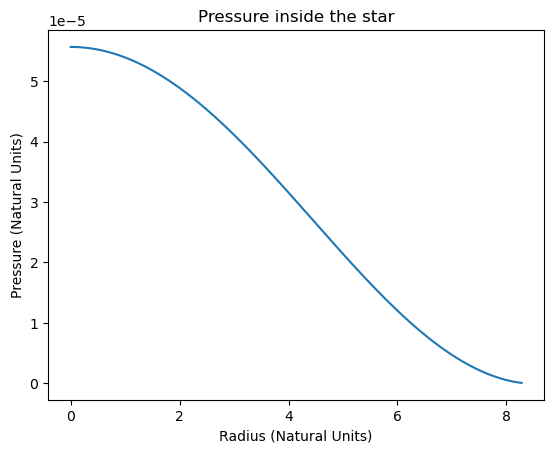

In [76]:
close("all")
title("Pressure inside the star")
xlabel("Radius (Natural Units)")
ylabel("Pressure (Natural Units)")
plot(R,Pm[:,1])
gcf()

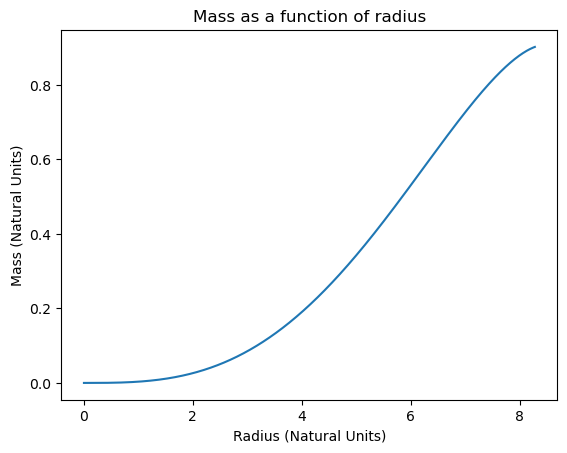

In [77]:
close("all")
title("Mass as a function of radius")
xlabel("Radius (Natural Units)")
ylabel("Mass (Natural Units)")
plot(R,Pm[:,2])
gcf()

#### Varying the central Density

Radius: 7.3300000001 in natural units 
Radius: 10.8190800001476 km 
Mass: 0.33731228838987404 in natural units
Mass: 6.713899369150565e29 kg
Radius: 8.0500000001 in natural units 
Radius: 11.881800000147601 km 
Mass: 0.6762120768634 in natural units
Mass: 1.3459396507421944e30 kg
Radius: 8.3500000001 in natural units 
Radius: 12.324600000147598 km 
Mass: 1.0099805455177353 in natural units
Mass: 2.010275931474018e30 kg
Radius: 8.4300000001 in natural units 
Radius: 12.4426800001476 km 
Mass: 1.3046238185994958 in natural units
Mass: 2.5967370102301026e30 kg
Radius: 8.4100000001 in natural units 
Radius: 12.4131600001476 km 
Mass: 1.5505322249160312 in natural units
Mass: 3.0861956961019715e30 kg
Radius: 8.3200000001 in natural units 
Radius: 12.2803200001476 km 
Mass: 1.7471781943463318 in natural units
Mass: 3.4776019079557495e30 kg
Radius: 8.2000000001 in natural units 
Radius: 12.103200000147599 km 
Mass: 1.9008305882236347 in natural units
Mass: 3.783433253515548e30 kg
Radius: 8.06

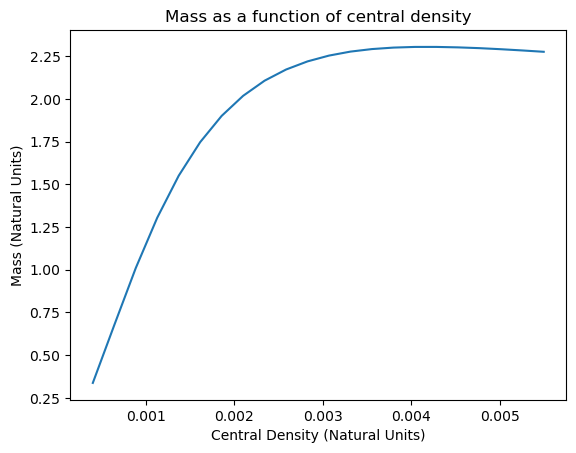

In [94]:
ρ_arr = 0.5ρ₀:0.3ρ₀:7ρ₀
Mᵨ_arr = zeros(length(ρ_arr))
for (ρ₀ᵢ,i) in zip(ρ_arr,1:length(ρ_arr))
    R,Pm=make_star(ρ₀ᵢ,Γ,κ,0.01,P,rₘₐₓ=100);
    Mᵨ_arr[i] = Pm[end,2]
end

print("---------------------------------------------------\n")
print("Maximum mass possible for this equation of state: ", maximum(Mᵨ_arr), " (in natural units)\n")
close("all")
title("Mass as a function of central density")
xlabel("Central Density (Natural Units)")
ylabel("Mass (Natural Units)")
plot(ρ_arr,Mᵨ_arr)
gcf()


#### Varying $\kappa$

Radius: 3.6500000001 in natural units 
Radius: 5.3874000001476 km 
Mass: 0.0835747396453831 in natural units
Mass: 1.663480433696837e29 kg
Radius: 5.1300000001 in natural units 
Radius: 7.571880000147599 km 
Mass: 0.22326249542476703 in natural units
Mass: 4.4438402595484045e29 kg
Radius: 6.1800000001 in natural units 
Radius: 9.121680000147599 km 
Mass: 0.38441482742960903 in natural units
Mass: 7.651433274760154e29 kg
Radius: 7.0100000001 in natural units 
Radius: 10.346760000147599 km 
Mass: 0.5551569840228295 in natural units
Mass: 1.1049903170151734e30 kg
Radius: 7.7000000001 in natural units 
Radius: 11.3652000001476 km 
Mass: 0.7291193246707215 in natural units
Mass: 1.4512467948645288e30 kg
Radius: 8.2800000001 in natural units 
Radius: 12.221280000147598 km 
Mass: 0.9019426974716935 in natural units
Mass: 1.7952362590970898e30 kg
Radius: 8.7800000001 in natural units 
Radius: 12.959280000147599 km 
Mass: 1.0715399832341614 in natural units
Mass: 2.132804485658166e30 kg
Radius:

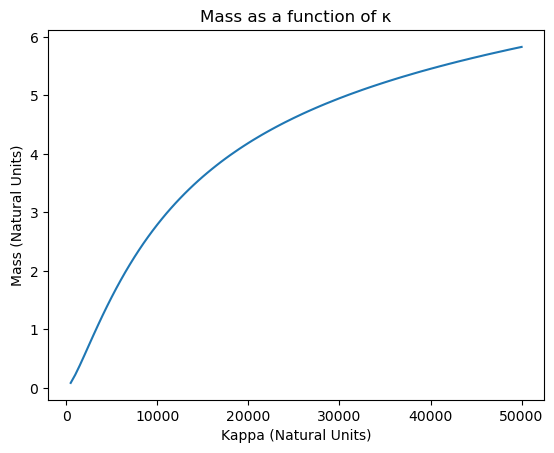

In [105]:
κ_arr = 500:500:50000
Mᵨ_arr = zeros(length(κ_arr))
for (κᵢ,i) in zip(κ_arr,1:length(κ_arr))
    R,Pm=make_star(ρ₀,Γ,κᵢ,0.01,P,rₘₐₓ=100);
    Mᵨ_arr[i] = Pm[end,2]
end

print("---------------------------------------------------\n")
close("all")
title("Mass as a function of κ")
xlabel("Kappa (Natural Units)")
ylabel("Mass (Natural Units)")
plot(κ_arr,Mᵨ_arr)
gcf()


### Varying $\Gamma$

Radius: 99.99000000010001 in natural units 
Radius: 147.58524000014762 km 
Mass: 6.425569865587089e-7 in natural units
Mass: 1.2789522039924916e24 kg
Radius: 99.99000000010001 in natural units 
Radius: 147.58524000014762 km 
Mass: 0.0003090400018954495 in natural units
Mass: 6.1511647964925854e26 kg
Radius: 99.99000000010001 in natural units 
Radius: 147.58524000014762 km 
Mass: 0.06626368665269199 in natural units
Mass: 1.3189194088917595e29 kg
Radius: 99.99000000010001 in natural units 
Radius: 147.58524000014762 km 
Mass: 2.073419521490444 in natural units
Mass: 4.1269560868263496e30 kg
Radius: 99.99000000010001 in natural units 
Radius: 147.58524000014762 km 
Mass: 17.35571243166863 in natural units
Mass: 3.454499309893408e31 kg
Radius: 99.99000000010001 in natural units 
Radius: 147.58524000014762 km 
Mass: 30.12929113737171 in natural units
Mass: 5.996965889554176e31 kg
Radius: 27.1700000001 in natural units 
Radius: 40.1029200001476 km 
Mass: 8.737753835425194 in natural units
M

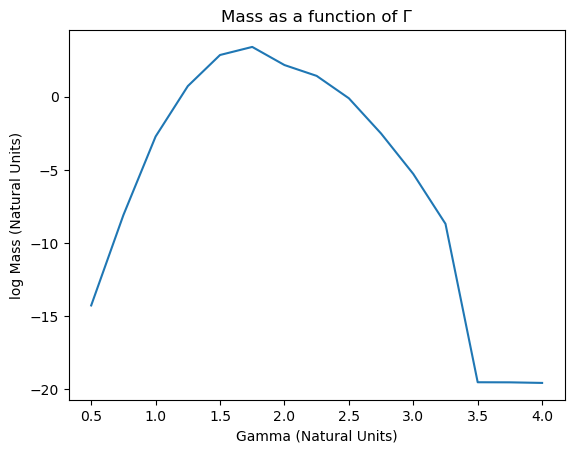

In [104]:
Γ_arr = 0.5:0.25:4
Mᵨ_arr = zeros(length(Γ_arr))
for (Γᵢ,i) in zip(Γ_arr,1:length(Γ_arr))
    R,Pm=make_star(ρ₀,Γᵢ,κ,0.01,P,rₘₐₓ=100);
    Mᵨ_arr[i] = Pm[end,2]
end

print("---------------------------------------------------\n")
close("all")
title("Mass as a function of Γ")
xlabel("Gamma (Natural Units)")
ylabel("log Mass (Natural Units)")
plot(Γ_arr,log.(Mᵨ_arr))
gcf()
